## Задание: Сегментировать покупателей по профилю потребления. Ответить на вопрос: как сегментация может помочь в разработке более персонализированных предложений для покупателей. 

## Содержание:

2.1 [Общая информация. Предобработка данных](#start)

2.2 [Исследовательский анализ данных](#eda)

2.3 [Анализ пользователей после сегментации](#seg)

2.4 [Проверка гипотез о равенстве среднего чека двух категорий](#gip)

2.5 [Выводы и рекомендации](#rec)

### Предобработка данных <a id="start"></a>

In [1]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pymystem3 import Mystem
import re
from scipy import stats as st
import math as mth
import plotly.express as px
from plotly import graph_objects as go
import scipy.stats as stats

In [2]:
df = pd.read_csv('/datasets/ecommerce_dataset.csv')

In [3]:
display(df.sample(10))

,date,customer_id,order_id,product,quantity,price
3191,2019042621,8cf3c949-8d92-40ad-a5fa-d67a4b49456d,71300,Коврик Dasch для ванной комнаты 50х80 см HJ-C ...,1,637.0
4645,2019060515,bc00e385-5eba-404d-912e-f119769b1206,71617,Коврик придверный Attribute NATURE кокосовый 6...,10,376.0
138,2018100813,bc59104e-73fb-4057-a65d-2325dc4b69dd,68569,Ёрш для бутылки из натурального волокна и мета...,10,142.0
6087,2019081310,a688224b-38c6-4fab-9d0e-f9c7b0ac6d13,72276,Штора для ванной Spirella / Спирелла Peva Hugo...,1,975.0
3158,2019042517,28195156-9812-4a27-a3e3-a1ebf41b5d64,14693,"Вербена Red красная объем 0,5 л",2,90.0
4465,2019060412,d2b12dec-4755-483b-b522-48cef83e4731,71595,Сушилка для белья настенная Zalger Prima 510-7...,1,299.0
169,2018100917,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68591,Тележка багажная DELTA ТБР-20 синий грузоподъе...,1,742.0
5052,2019061022,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,"Рассада Кабачка сорт Сосновский, кассета по 6шт",1,120.0
3873,2019051710,1420716a-02ef-426f-828d-fddcb0e1f532,14786,Бегония вечноцветущая рассада однолетних цвето...,1,128.0
2049,2019022709,377c8a20-a3e0-4945-9fd8-a1f4ada5d8b0,70482,Муляж Банан желтый 21 см полиуретан,50,51.0


Датасет описывает транзакции интернет-магазина товаров для дома и быта «Пока все ещё тут». 

Наименование колонок:
* date — дата заказа;
* customer_id — идентификатор покупателя;
* order_id — идентификатор заказа;
* product — наименование товара;
* quantity — количество товара в заказе;
* price — цена товара.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


В базе данных 6737 событий, пропущенных значений нет. Наименования колонок - коректны, и не требуют изменений.

Проведем проверку на дубликаты. для этого приведем данные столбца product к нижнему регистру:

In [5]:
df['product'] = df['product'].str.lower()

In [6]:
print(df.duplicated().sum())

0


Дубликатов в данной базе данных не обнаружено.

Проверим базу на скрытые дубликаты - это те транзакции, в которых совпаает номер заказа, номер покупателя и наименование продукта:

In [7]:
display(df[['customer_id','order_id', 'product']].duplicated().sum())

1886

Около 30% базы составляют не явные дубликаты - возможно это ошибки подсчета заказов при оформлении или при выгрузке базы. Для дальнейшего анализа нужно удалить дубликаты:

In [8]:
df = df.drop_duplicates(['customer_id','order_id', 'product'])
len(df)

4851

In [9]:
display(df[['customer_id','order_id', 'product']].duplicated().sum())

0

Требуется привести данные в столбце "date", к формату datetime:

In [10]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')

In [11]:
display(df.sample(5))

,date,customer_id,order_id,product,quantity,price
1100,2018-12-04 12:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,69202,сушилка для белья ника сб1 18 м,1,689.0
6602,2019-10-13 17:00:00,5901a4c4-768d-4dc5-9d81-3546e29820fb,72951,пеларгония зональная ринго вайт d-7 см h-10 см...,1,74.0
2260,2019-03-09 19:00:00,80e311a3-2a1f-4a56-b307-d25c1f402048,70672,гладильная доска ника валенсия fashion valensi...,1,2399.0
1328,2018-12-23 19:00:00,ce0e2f13-d360-4ab5-a970-261d25e770e8,69534,фоторамка alparaisa на 7 фотографий бронзовая ...,1,300.0
1419,2018-12-29 09:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,69680,пуансеттия d-12 см красная,1,134.0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4851 entries, 0 to 6735
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         4851 non-null   datetime64[ns]
 1   customer_id  4851 non-null   object        
 2   order_id     4851 non-null   int64         
 3   product      4851 non-null   object        
 4   quantity     4851 non-null   int64         
 5   price        4851 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 265.3+ KB


Данные столбца "date" переведены в формат datetime64. в нем содержится год, месяц, день и час заказа.

### Исследовательский анализ данных <a id="eda"></a>

Выведим общую инфрмацию о значениях данных в БД:

In [13]:
df.describe()

,order_id,quantity,price
count,4851.000000,4851.000000,4851.000000
mean,48267.589981,2.833643,516.063698
std,27333.809628,17.642900,946.096518
min,12624.000000,1.000000,9.000000
25%,14774.000000,1.000000,90.000000
50%,68860.000000,1.000000,150.000000
75%,70835.500000,1.000000,502.000000
max,73164.000000,1000.000000,14917.000000






В базе данных представлено 4851 транзакций. Минимальная цена позиции составляет - 9, максимальная - 14917, минимальное количество покупаемых товаров за транзакцию - 1, максимальное - 1000, при медианном значении 1 это очень похоже на выброс, проверим все признаки подробнее на предмет выбросов и аномалий:


Распределение количества позиций (quantity) в транзакциях:

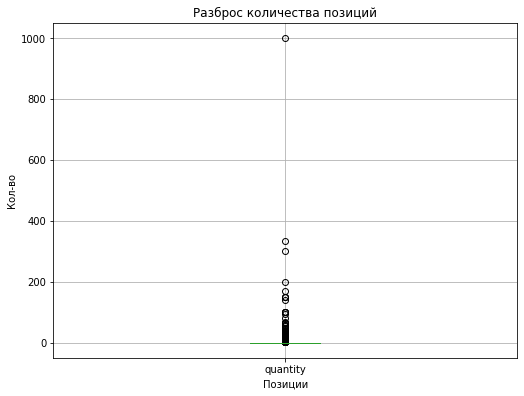

In [14]:
df.boxplot(column='quantity',figsize=(7, 5))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.title('Разброс количества позиций')
plt.xlabel('Позиции')
plt.ylabel('Кол-во')
plt.show()



Более 200 позиций редко встречаются в рамках одной транзакции, выведим их отдельно:


In [15]:
display(df.query('quantity>200'))

,date,customer_id,order_id,product,quantity,price
3961,2019-05-20 21:00:00,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,муляж яблоко 9 см красное,300,51.0
5071,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"вантуз с деревянной ручкой d14 см красный, bur...",1000,675.0


Таких событий в базе - 3 шт, скорее всего это либо оптовые закупки, либо ошибка в транзакции. Для предотвращения дальнейшего искажения результатов анализа, эти события я не буду принимать в рассчет:

In [16]:
df = df.query('quantity<200')

Распределение цен (price) в заказе:

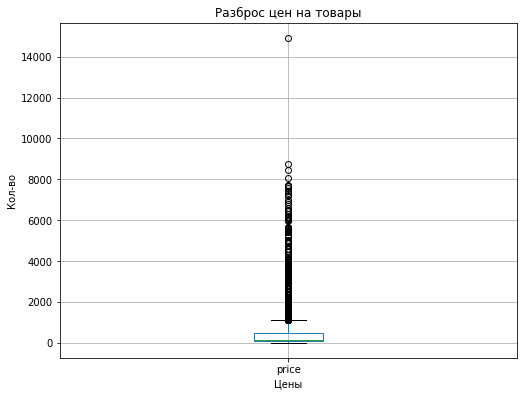

In [17]:
df.boxplot(column='price',figsize=(7, 5))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.title('Разброс цен на товары')
plt.xlabel('Цены')
plt.ylabel('Кол-во')
plt.show()

Цены на товар редко превышают 8000р, выведем и просмоторим дорогие позиции:

In [18]:
display(df.query('price>8000'))

,date,customer_id,order_id,product,quantity,price
1981,2019-02-24 10:00:00,ac250053-a236-467a-97d2-ddbb9bf4a1ba,70423,сумка-тележка хозяйственная andersen alu star ...,1,8437.0
2697,2019-04-05 19:00:00,c0c60544-3a99-49d0-8a8e-cf7f293c22cb,71035,сумка-тележка хозяйственная andersen royal sho...,1,8737.0
2997,2019-04-21 16:00:00,19d904d8-8d16-476d-8f66-b2a3b7a23660,71227,сумка-тележка хозяйственная rolser mnb019 rojo...,1,8077.0
5992,2019-07-29 17:00:00,0d87f4ae-465a-4fac-81e6-5d629761783e,72139,сушилка уличная leifheit 85210 linomatic v 400...,1,14917.0


Проверив эти 4 позиции вручную, поиском, мы убедились, что данные цены являются достоверными, поэтому удалять из базы их не нужно.

Т.к. в базе данных указаны цена на единицу товара, то нужно добавить новый столбец с итоговой суммой заказа "order_price":

In [19]:
df['order_price'] = df['quantity'] * df['price']

Также добавим в базу столбец с годом заказа, месяцем заказа, неделей заказа, и днем заказа для нахождения дальнейших метрик:

In [20]:
df['order_month'] = df['date'].astype('datetime64[M]')
df['year']  = df['date'].dt.year
df['month']  = df['date'].dt.month
df['week']  = df['date'].dt.isocalendar().week
df['day']  = df['date'].dt.date

In [21]:
display(df.sample(5))

,date,customer_id,order_id,product,quantity,price,order_price,order_month,year,month,week,day
2236,2019-03-07 10:00:00,a8b088ec-7c45-4dda-bc86-2ffcc861d8d8,14565,пеларгония зональная махровая белая взрослое р...,1,150.0,150.0,2019-03-01,2019,3,10,2019-03-07
1706,2019-02-05 20:00:00,673d44a3-9cec-4c2f-b0c6-9be4952ddc7c,70114,вешалка-плечики без эссенции цвет тёмно-розовы...,30,40.0,1200.0,2019-02-01,2019,2,6,2019-02-05
771,2018-11-11 22:00:00,76e12e82-776d-47fb-b2fa-822233c5ae79,68957,овощечистка с плавающим лезвием comfortline из...,1,749.0,749.0,2018-11-01,2018,11,45,2018-11-11
3698,2019-05-13 17:00:00,dabea2a5-f3e2-4137-b96f-a305dffaf5a8,71412,"сушилка для белья потолочная лиана 1,3 м 1703002",1,509.0,509.0,2019-05-01,2019,5,20,2019-05-13
6657,2019-10-20 19:00:00,e2e51402-7dcd-4973-873b-be978dfb3ef3,14945,пеларгония зональная диам. 12 см сиреневый пол...,1,150.0,150.0,2019-10-01,2019,10,42,2019-10-20


In [22]:
print('Первая дата заказа:', df['date'].min())
print('Последняя дата заказа:', df['date'].max())

Первая дата заказа: 2018-10-01 00:00:00
Последняя дата заказа: 2019-10-31 14:00:00


Данные представлены за 1 год с 01.10.2018 по 31.10.2019.

Проведем категоризацию данных, по признаку "product":

In [23]:
print(df['product'].value_counts(). sample(5))

аргирантерум рассада однолетних цветов в горшке диам. 12 см    2
салатник luminarc арти пинк 16,5 см l2857                      1
сушилка для белья потолочно-настенная gimi lift 160            2
петуния orange morn оранжевая объем 0,5 л                      3
гладильная доска ника bruna m hbm 122х40 см                    3
Name: product, dtype: int64


В строках есть повторяющиеся слова, такие как "рассада", "черенок", "кассета" - поэтому проведем лемматизацию, чтобы разбить покупки на категории:

In [24]:
m = Mystem()
df['lemmas'] = df['product'].apply(m.lemmatize)

In [25]:
display(df.sample(5))

,date,customer_id,order_id,product,quantity,price,order_price,order_month,year,month,week,day,lemmas
5567,2019-06-24 17:00:00,b6662d1b-b30d-46ab-ad5c-b1780f143298,71788,сумка-тележка 2-х колесная gimi argo красная,1,1087.0,1087.0,2019-06-01,2019,6,26,2019-06-24,"[сумка, -, тележка, , 2, -, х, , колесный, ..."
1213,2018-12-15 15:00:00,b671b176-6d01-43f4-a168-a22ef061b2fd,69375,"ёрш унитазный с деревянной ручкой , ваир 1712012",1,59.0,59.0,2018-12-01,2018,12,50,2018-12-15,"[ерш, , унитазный, , с, , деревянный, , ру..."
2114,2019-03-01 15:00:00,e574a1f2-4102-412c-af15-dde56abb7bf7,70537,"ёрш унитазный с деревянной ручкой , ваир 1712012",23,56.0,1288.0,2019-03-01,2019,3,9,2019-03-01,"[ерш, , унитазный, , с, , деревянный, , ру..."
1974,2019-02-23 18:00:00,533fc3fd-9412-49d4-90f5-fd9301dc48b9,14547,рассада зелени для кухни розмарин блю лагун ди...,1,119.0,119.0,2019-02-01,2019,2,8,2019-02-23,"[рассада, , зелень, , для, , кухня, , розм..."
5732,2019-07-09 15:00:00,1441d772-6f55-490f-8edf-171bef655b16,14896,рассада зелени для кухни розмарина в горшке ди...,1,120.0,120.0,2019-07-01,2019,7,28,2019-07-09,"[рассада, , зелень, , для, , кухня, , розм..."


На первый взгляд можно выделить следующие категории: "расстения", "декор", "посуда", "хозяйственные товары", "текстиль", "храненение", "ремонт", "электроприборы". Те товары в категориях которых я сомневаюсь, я помещу временно в категорию "другое". 

Далее я переведу значения столбца 'lemmas' в строковый формат, чтобы использовать более удобный функции для выделения слов, введу 2 фильтра 1-е и затем 3-е слово, по которым буду проводить разбивку на категории:

In [26]:
df['lemmas'] = df['lemmas'].astype(str)
df['first'] = df['lemmas'].str.split(' ').str[0]
#df['second'] = df['lemmas'].str.split(' ').str[2]- не используем, т.к. второе слово не информативно
df['therd'] = df['lemmas'].str.split(' ').str[3]

Найдем уникальные значения, и сохраним их в списках v_1 и v_3:

In [27]:
v_1 = df['first'].unique()
v_3 = df['therd'].unique()

Введем функцию, которая сохранит только русские слова в списках - так мы избавимся от лишних символов и пробелов:

In [28]:
#функция выделения слов
def find_word (words):
    s = []
    for word in words: 
        i = ''.join(re.findall('[а-я ]', word))
        s.append(i)
    return s
x_1 = find_word (v_1)
x_3 = find_word (v_3)

Введем функцию, которая сохранит только русские слова в столбцах таблицы, которые мы будем в дальнейшем использовать для категоризации: 

In [29]:
#Напишем функцию, которая оcтавит в столбце только слова (без символов)
def az (row):
    new = ''.join(re.findall('[а-я ]', row))
    return new
df['first'] = df['first'].apply(az)
df['therd'] = df['therd'].apply(az) 

Создадим списки для разбивки на категории, распределим вручную первые слова по категориям. Разбивку проводила вручную - сначала разбивала "знакомы слова" из более мелких категорий, категорию расстений я выделила вычитанием из общего списка распределенных элементов:


In [30]:
#посуда
dishes_1 = ['сковорода', 'стеклянный', 'доска', 'тарелка', 'вилка', 'ложка', 'нож', 'котел', 'кувшин', 'толкушка', 'противень', 'мокружка', 'масленка', 'сервировочный', 'салатник', 'чайный', 'рыбочистка', 'овощеварка', 'терка', 'кружка', 'лопатка', 'салфетница', 'стакан', 'столовый','овощечистка', 'мантоварка', 'кухонный', 'кисточка', 'картофелемялка', 'подставка', 'миска', 'термостакан', 'термокружок', 'термос', 'фарфоровый', 'блюдце', 'бульонница', 'разделочный', 'складной', 'емкость','просеиватель', 'кастрюля', 'форма', 'орехоколка', 'скалка', 'венчик', 'сито', 'тортница', 'блюдо', 'сотейник', 'бидон', 'крышка', 'сахарница', 'половник', 'мерный', 'фужер', 'бокал', 'посуда', 'эмалированный']

In [31]:
#хоз.товары
household_goods_1 = ['настенный', 'сушилка', 'крючок', 'сумка', 'подкладка', 'дозатор', 'стремянка', 'лестница', 'тележка','стяжка', 'насадка', 'ножеточка', 'сидение', 'корыто', 'измерительный', 'линейка', 'бензин', 'держатель', 'пробка', 'измельчитель', 'термометр', 'шило', 'ковш', 'рассекатель', 'весы', 'пресс','кольцо', 'штангенциркуль', 'фиксатор', 'шпагат', 'отделитель', 'шприц', 'веревка']

In [32]:
#бытовая химия, уборка
cleaning_1 = ['таз','щетка', 'ерш', 'перчатка', 'гладильный', 'стиральный', 'чистить', 'пена', 'зубной', 'веник', 'швабра', 'ведро', 'мыло', 'сметка', 'паста', 'губка', 'антижир', 'ролик', 'сменный', 'косметь', 'скребок', 'ароматизированный', 'бальзам', 'ополаскиватель', 'сетка', 'вантуз', 'кондиционер', 'гипоаллергенный', 'совок', 'увлажнять', 'концентрат', 'окномойка', 'тряпкодержатель', 'бельевой', 'молодить', 'отжим', 'антинакипин', 'отбеливатель', 'тряпка', 'средство']

In [33]:
#текстиль
textile_1 = ['коврик', 'плед', 'скатерть', 'ковер', 'простыня', 'штора','подушка', 'полотенце', 'салфетка', 'вкладыш',  'подрукавник', 'подголовник', 'наматрасник', 'наматрицник', 'халат', 'покрывало', 'одеяло', 'махровый', 'нетканый', 'рукав', 'ткань', 'наматрацник', 'наволочка', 'пододеяльник', 'двуспальный', 'постельный']

In [34]:
#декор 
decor_1 = ['муляж', 'искусственный', 'декоративный', 'новогодний', 'мыльница', 'фоторамка', 'ваза']

In [35]:
#хранение 
storage_1 = ['чехол', 'вешалка', 'корзина', 'банка', 'плечики', 'кофр', 'контейнер', 'ящик', 'короб', 'коробка', 'урна', 'лоток', 'комод', 'этажерка', 'полка', 'ключница', 'модульный', 'хлебница', 'штанга', 'бак', 'полк', 'обувница', 'стеллаж', 'корзинка', 'мешок']

In [36]:
#ремонт 
repairs_1 = ['мусорный', 'крепеж', 'пружина', 'петля', 'сверло', 'карниз', 'ванна', 'завертка', 'ручка', 'решетка', 'шпингалет','прецизионный', 'инструмент', 'свереть']

In [37]:
#электроприборы
electrical_1 = ['чайник', 'миксер', 'светильник', 'утюг', 'шнур', 'фен', 'электроштопор', 'пылесос', 'подвесной', 'соковарка', 'пьезозажигалка', 'соковыжималка', 'вакуумный', 'кипятильник', 'основание']

In [38]:
#другое
other_1 = ['мини', 'набор', 'готовый', 'комплект', 'кампануть', 'жидкий', 'иссоп', 'настольный', 'средство', 'универсальный', 'жестяной', 'защитный', 'многофункциональный', 'подарочный', 'автоматический', 'покрытие', 'запасный', 'основание']

In [39]:
#расстения
flower_1 = list(set(x_1) - set(dishes_1) - set(household_goods_1) - set(cleaning_1) - set(textile_1) - set(decor_1) - set(storage_1) - set(repairs_1)-set(electrical_1)-set(other_1))

Напишем функцию для категоризации данных:

In [40]:
def segment_group(segment):
    if segment in dishes_1:
        return 'посуда'
    if segment in household_goods_1:
        return 'хоз.товары'
    if segment in cleaning_1:
        return 'уборка'
    if segment in textile_1:
        return 'текстиль'
    if segment in decor_1:
        return 'декор'
    if segment in storage_1:
        return 'хранение'
    if segment in repairs_1:
        return 'ремонт'
    if segment in electrical_1:
        return 'электроприборы'
    if segment in other_1:
        return 'другое'
    if segment in flower_1:
        return 'расстения'
    return 'другое'


In [41]:
df['segment_group'] = df['first'].apply(segment_group) 
display(df.sample(5))

,date,customer_id,order_id,product,quantity,price,order_price,order_month,year,month,week,day,lemmas,first,therd,segment_group
40,2018-10-02 11:00:00,1bc8ad38-3392-4042-8cde-aa5de306c947,68494,"муляж томат, оранжевый, 9 см, полиуретан, fanc...",1,104.0,104.0,2018-10-01,2018,10,40,2018-10-02,"['муляж', ' ', 'томат', ', ', 'оранжевый', ', ...",муляж,томат,декор
2159,2019-03-04 15:00:00,0f47231c-3a68-404a-88f7-08a4a172c17f,14559,"горох амброзия 10,0 г 4660010772616",1,9.0,9.0,2019-03-01,2019,3,10,2019-03-04,"['горох', ' ', 'амброзия', ' ', '10', ',', '0'...",горох,амброзия,расстения
6642,2019-10-17 12:00:00,87b91327-f408-4329-afdd-c1bd08ee9485,14944,рассада зелени для кухни шпинат в кассете 6 шт,2,116.0,232.0,2019-10-01,2019,10,42,2019-10-17,"['рассада', ' ', 'зелень', ' ', 'для', ' ', 'к...",рассада,зелень,расстения
937,2018-11-23 13:00:00,b45f5679-ee10-4c52-bdd3-cb714961feaf,14509,пеларгония розоцветная ред розебуд молодые рас...,1,150.0,150.0,2018-11-01,2018,11,47,2018-11-23,"['пеларгония', ' ', 'розоцветный', ' ', 'ред',...",пеларгония,розоцветный,расстения
1058,2018-12-02 15:00:00,036118cf-c198-48fa-ba15-6d841482a56d,69176,тарелка суповая воларэ блэк 23 см g9402 luminarc,3,127.0,381.0,2018-12-01,2018,12,48,2018-12-02,"['тарелка', ' ', 'суповой', ' ', 'воларэ', ' '...",тарелка,суповой,посуда


In [42]:
df['segment_group'].value_counts()

расстения         2482
хоз.товары         765
уборка             334
хранение           291
текстиль           291
декор              265
посуда             246
другое              75
электроприборы      63
ремонт              35
Name: segment_group, dtype: int64

In [43]:
df['segment_group_1'] = df['therd'].apply(segment_group)

Проведем категоризацию по 3-ему слову, тех товаров, которые попали в категорию "другое"

In [44]:
df['segment_group'] = np.where(df['segment_group'] == 'другое', df['segment_group_1'], df['segment_group'])

In [45]:
df['segment_group'].value_counts()

расстения         2483
хоз.товары         766
уборка             338
хранение           304
текстиль           300
посуда             271
декор              265
электроприборы      63
ремонт              39
другое              18
Name: segment_group, dtype: int64

In [46]:
display(df.query('segment_group in "другое"').sample(5))

,date,customer_id,order_id,product,quantity,price,order_price,order_month,year,month,week,day,lemmas,first,therd,segment_group,segment_group_1
6202,2019-08-27 09:00:00,5956b1f9-6d1b-4731-a38b-ce2434c499bd,72429,покрытие для гладильной доски leifheit reflect...,1,712.0,712.0,2019-08-01,2019,8,35,2019-08-27,"['покрытие', ' ', 'для', ' ', 'гладильный', ' ...",покрытие,для,другое,другое
2076,2019-03-01 08:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,70523,подарочный набор на 8 марта пеларгония красная...,2,194.0,388.0,2019-03-01,2019,3,9,2019-03-01,"['подарочный', ' ', 'набор', ' ', 'на', ' ', '...",подарочный,набор,другое,другое
1252,2018-12-18 10:00:00,baa2d893-381c-4eca-9edc-a02c2b3ecf4a,69432,защитный экран подставка и дуршлаг webber 3 в ...,1,442.0,442.0,2018-12-01,2018,12,51,2018-12-18,"['защитный', ' ', 'экран', ' ', 'подставка', '...",защитный,экран,другое,другое
2128,2019-03-03 08:00:00,8bf5928c-2fa8-4b4a-9896-aadad9f11295,70556,набор vileda easy wring & clean turbo 151153 в...,1,2924.0,2924.0,2019-03-01,2019,3,9,2019-03-03,"['набор', ' ', 'vileda', ' ', 'easy', ' ', 'wr...",набор,,другое,другое
15,2018-10-01 18:00:00,17213b88-1514-47a4-b8aa-ce51378ab34e,68476,"мини-сковорода marmiton ""сердце"" с антипригарн...",1,239.0,239.0,2018-10-01,2018,10,40,2018-10-01,"['мини', '-', 'сковорода', ' ', 'marmiton', ' ...",мини,,другое,другое


In [47]:
(df.query('segment_group in "другое"')['first']).value_counts()

подарочный    6
покрытие      4
защитный      2
набор         2
комплект      2
иссоп         1
мини          1
Name: first, dtype: int64

Проверим вручную, какие товары не распределились, вернемся к спискам категорий, и добавим их наименования в них.

In [48]:
# Здесь я проводила поочередную выборку товаров - вспомогательный код
#df.query('(segment_group in "другое") & (first in "набор" )')

In [49]:
df.loc[df['first'] == 'подарочный', 'segment_group'] = 'расстения'
df.loc[df['first'] == 'иссоп', 'segment_group'] = 'расстения'
df.loc[df['first'] == 'покрытие', 'segment_group'] = 'уборка'
df.loc[df['therd'] == 'соль', 'segment_group'] = 'уборка'
df.loc[df['first'] == 'защитный', 'segment_group'] = 'посуда'
df.loc[df['first'] == 'мини', 'segment_group'] = 'посуда'
df.loc[df['first'] == 'комплект', 'segment_group'] = 'уборка'
df.loc[(df['first'] == 'набор')&(df['therd'] == 'для'), 'segment_group'] = 'посуда'
df.loc[df['first'] == 'набор', 'segment_group'] = 'уборка'

In [50]:
(df.query('segment_group in "другое"')['first']).value_counts()

Series([], Name: first, dtype: int64)

На данный момент все товары распределены по следующим категориям:

In [51]:
df['segment_group'].value_counts()

расстения         2489
хоз.товары         766
уборка             389
хранение           296
текстиль           293
декор              265
посуда             250
электроприборы      63
ремонт              36
Name: segment_group, dtype: int64

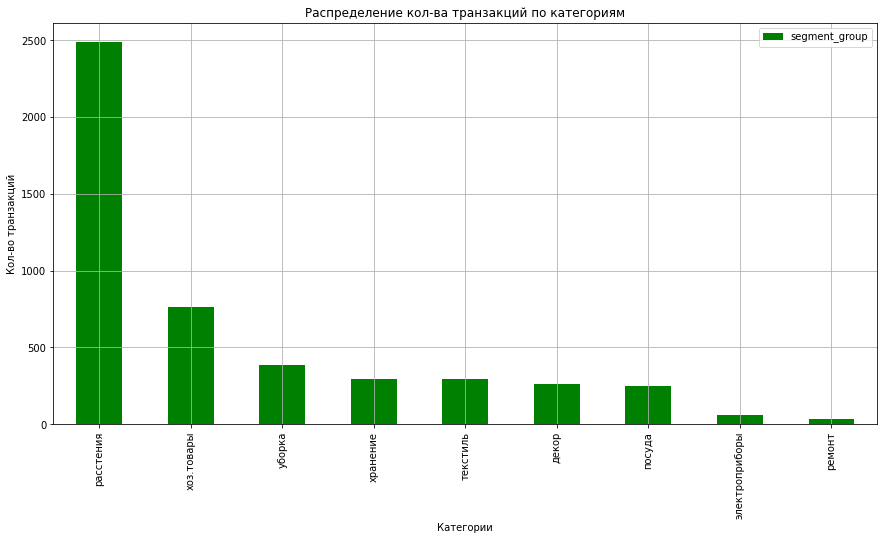

In [52]:
df['segment_group'].value_counts().plot(kind='bar', ylim=0, grid=True, figsize=(12, 7),legend=True, color='green')
plt.legend(loc='upper right')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.title('Распределение кол-ва транзакций по категориям')
plt.xlabel('Категории')
plt.ylabel('Кол-во транзакций')
plt.show()


Большиство транзакций относятся к категории "расстения", затем "хоз.товары". Меньше всего транзакций в разделе "ремонт" и "электроприборы".


    
Расчет заказов по категориям


 Найдем количество заказов, количество категорий, в которых покупаются товары и средний чек для каждого клиента:

In [53]:
df_customer_id = df.groupby(['customer_id']).agg({'segment_group': 'nunique', 'order_id': 'nunique', 'order_price': 'sum'}).reset_index().sort_values(by='order_id')

In [54]:
df_customer_id['check'] = df_customer_id['order_price']/df_customer_id['order_id']
display(df_customer_id)
#display(df_customer_id.info())

,customer_id,segment_group,order_id,order_price,check
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,1,555.0,555.000000
1600,ab46eafd-f9d3-4f91-af42-794d675d9c0c,1,1,157.0,157.000000
1601,ab938608-1b5b-4830-9fc0-dfc649c04b2f,1,1,177.0,177.000000
1602,abdc17c8-0813-4b05-9e10-1ffc77eea2d8,1,1,413.0,413.000000
1603,abeada3e-b1b7-48e6-b416-4acf56f24898,1,1,222.0,222.000000
...,...,...,...,...,...
17,0184f535-b60a-4914-a982-231e3f615206,1,5,5891.0,1178.200000
1744,b7b865ab-0735-407f-8d0c-31f74d2806cc,1,7,3779.0,539.857143
1098,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,5,17,21361.0,1256.529412
740,4d93d3f6-8b24-403b-a74b-f5173e40d7db,9,35,57278.0,1636.514286


Мы получили данные о 2447 клиентах. 

Присвоим клиентам, покупающим товары только в одной категории соответствующую категорию, а тем, кто покупает в 2-х и более разных категориях укажем категорию - "разные категории"

In [55]:
df_customer_id_1 = df_customer_id.merge(df[['customer_id','segment_group']], on ='customer_id', how='left')

In [56]:
df_customer_id_1 = df_customer_id_1.drop_duplicates(['customer_id','segment_group_x'])

In [57]:
df_customer_id_1['segment_group_y'] = np.where(df_customer_id_1['segment_group_x'] > 1, "разные категории", df_customer_id_1['segment_group_y'])

In [58]:
df_customer_id_1 = df_customer_id_1.rename(columns={'segment_group_x':'segment_count', 'segment_group_y':'segment_name'})
display(df_customer_id_1)

,customer_id,segment_count,order_id,order_price,check,segment_name
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,1,555.0,555.000000,расстения
4,ab46eafd-f9d3-4f91-af42-794d675d9c0c,1,1,157.0,157.000000,ремонт
5,ab938608-1b5b-4830-9fc0-dfc649c04b2f,1,1,177.0,177.000000,декор
6,abdc17c8-0813-4b05-9e10-1ffc77eea2d8,1,1,413.0,413.000000,декор
7,abeada3e-b1b7-48e6-b416-4acf56f24898,1,1,222.0,222.000000,расстения
...,...,...,...,...,...,...
4594,0184f535-b60a-4914-a982-231e3f615206,1,5,5891.0,1178.200000,расстения
4624,b7b865ab-0735-407f-8d0c-31f74d2806cc,1,7,3779.0,539.857143,расстения
4642,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,5,17,21361.0,1256.529412,разные категории
4659,4d93d3f6-8b24-403b-a74b-f5173e40d7db,9,35,57278.0,1636.514286,разные категории


В данном разделе мы выявили аномалии, и удалили их из базы данных. Также мы провели сигментацию пользователей, в ходе которой выявили, что большинство транзакций пренадлежит категории "расстения". Изучим подробнее пользователей, с точки зрения их разбивки на категории - для этого подготовлена база данных df_customer_id_1 с информацией о пользователе, количестве заказов, сумме заказов, среднем чеке, категориях покупаемых товаров.


### Анализ пользователей после сегментации  <a id="seg"></a>

Построим графики распределений покупок и сумм транзакций по категориям:

In [59]:
df_sum = df.pivot_table(index= 'order_month', columns='segment_group', values='order_price', aggfunc='sum').reset_index()

In [60]:
df_count = df.pivot_table(index= 'order_month', columns='segment_group', values='order_id', aggfunc='count').reset_index()

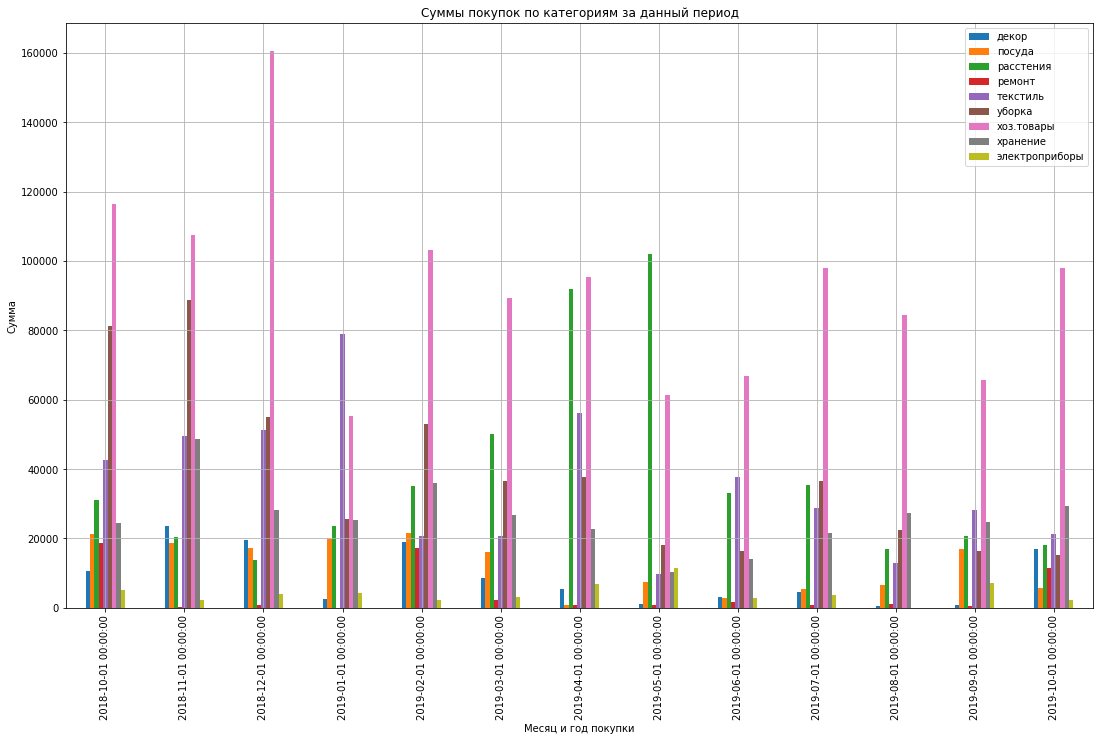

In [61]:
df_sum.plot(kind='bar', x='order_month', ylim=0, grid=True, figsize=(15, 10),legend=False)
plt.legend(loc='upper right')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.title('Суммы покупок по категориям за данный период')
plt.xlabel('Месяц и год покупки')
plt.ylabel('Сумма')
plt.show()

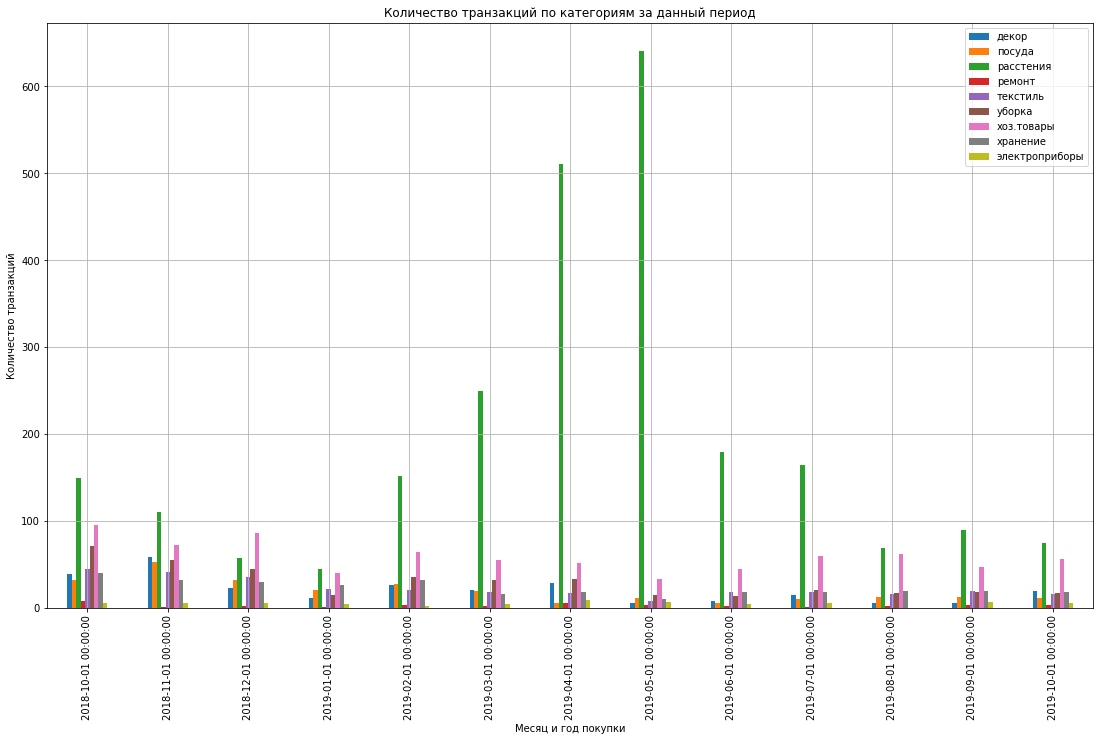

In [62]:
df_count.plot(kind='bar', x='order_month', ylim=0, grid=True, figsize=(15, 10),legend=False)
plt.legend(loc='upper right')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.title('Количество транзакций по категориям за данный период')
plt.xlabel('Месяц и год покупки')
plt.ylabel('Количество транзакций')
plt.show()

У некоторых категорий прослеживается сезонность:

"расстения" - стабильный рост количества транзакций наблюдается с февраля по июнь - время дачного сезона. Стоимость покупок пропорционально растет. С июля резко снижается, и до февраля нет значительных изменений.

"хоз.товары" - в течении года, по количеству транзакций данная категория стабильна, суммы покупок в большинстве месяцев году значительно выше других категорий. Единственный значительный скачок в стоимости наблюдается в декабре 2018 года.

"уборка" - самые крупные транзакции и по количеству и по сумме приходятся на период с октября по декабрь 2018года.

Остальные категории не отличаются яркой сезонностью.

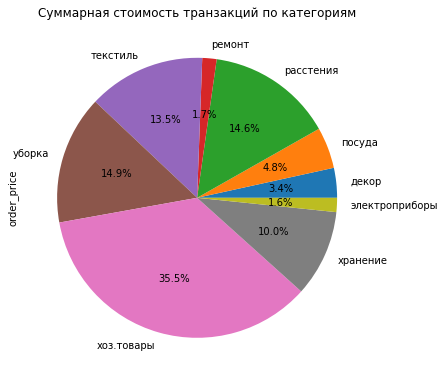

In [63]:
df.pivot_table(index='segment_group', values='order_price', aggfunc='sum').plot(kind='pie', y='order_price', x='segment_group', autopct='%1.1f%%',figsize=(6, 6), legend=False)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.title('Суммарная стоимость транзакций по категориям')
plt.show()

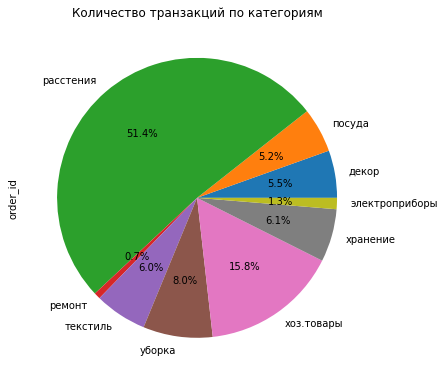

In [64]:
df.pivot_table(index='segment_group', values='order_id', aggfunc='count').plot(kind='pie', y='order_id', x='segment_group', autopct='%1.1f%%',figsize=(6, 6), legend=False)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.title('Количество транзакций по категориям')
plt.show()

Не смотря на то, что большиство транзакций - 51,4% сосредоточены в категории "расстения", в сумме стоимость заказов около 14,6%. Тогда, как сумма стоимости заказов категории "хоз. товары" 35,5% при доле транзакций 15,8%.

Рассчитаем следующие показатели:
* DAU (от англ. daily active users) — количество уникальных пользователей в день;
* WAU (от англ. weekly active users) — количество уникальных пользователей в неделю;
* MAU (от англ. monthly active users) — количество уникальных пользователей в месяц.

In [65]:
dau_total = df.groupby('day').agg({'customer_id': 'nunique'}).mean()
wau_total = df.groupby(['year', 'week']).agg({'customer_id': 'nunique'}).mean()
mau_total = df.groupby(['year', 'month']).agg({'customer_id': 'nunique'}).mean()
print('Количество уникальных пользователей в день:', int(dau_total))
print('Количество уникальных пользователей в неделю:', int(wau_total)) 
print('Количество уникальных пользователей в месяц:', int(mau_total)) 

Количество уникальных пользователей в день: 6
Количество уникальных пользователей в неделю: 44
Количество уникальных пользователей в месяц: 191


Проверим, как ежемесячно менялся MAU:

AxesSubplot(0.125,0.125;0.775x0.755)


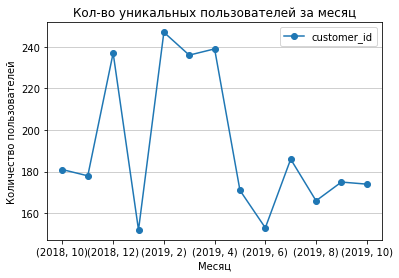

In [66]:
print(df.groupby(['year', 'month']).agg({'customer_id': 'nunique'}).plot(style='o-', legend = True))
plt.title('Кол-во уникальных пользователей за месяц')
plt.xlabel('Месяц')
plt.ylabel('Количество пользователей')
plt.grid(axis='y', alpha=0.75)
plt.show()

Ежедневно в среднем интернет-магазином пользуется 6 пользователей в день (44 в месяц и 191 в год). Большинство заказов уникальных пользователей приходится на 12.2018, 02.2019, 03.2019, 04.2019. Минимальное количество пользователей зафиксировано 01.2019 и 06.2019. Скорее всего это обуславливается сезонность представленных товаров.

Найдем средний чек:

In [67]:
orders_check = df.groupby(['segment_group']).agg({'order_price': ['mean']})
display(orders_check)
print()
print('Cредний чек магазина: ', int(orders_check.mean()))

,order_price
,mean
segment_group,
декор,439.679245
посуда,644.656000
расстения,198.018080
ремонт,1551.611111
текстиль,1565.170648
уборка,1293.920308
хоз.товары,1569.344648
хранение,1146.307432



Cредний чек магазина:  1031


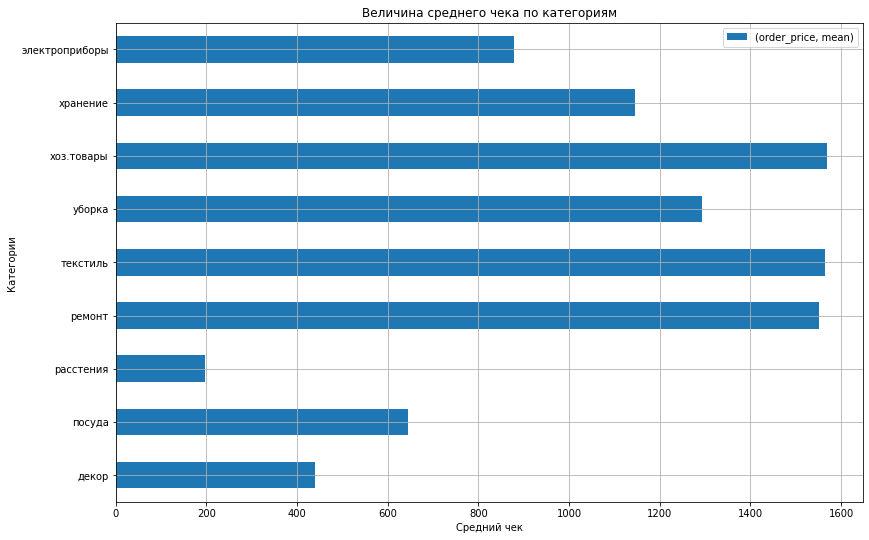

In [68]:
orders_check.plot(kind='barh', ylim=0, grid=True, figsize=(12, 7),legend=False)
plt.legend(loc='upper right')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.title('Величина среднего чека по категориям')
plt.xlabel('Средний чек')
plt.ylabel('Категории')
plt.show()

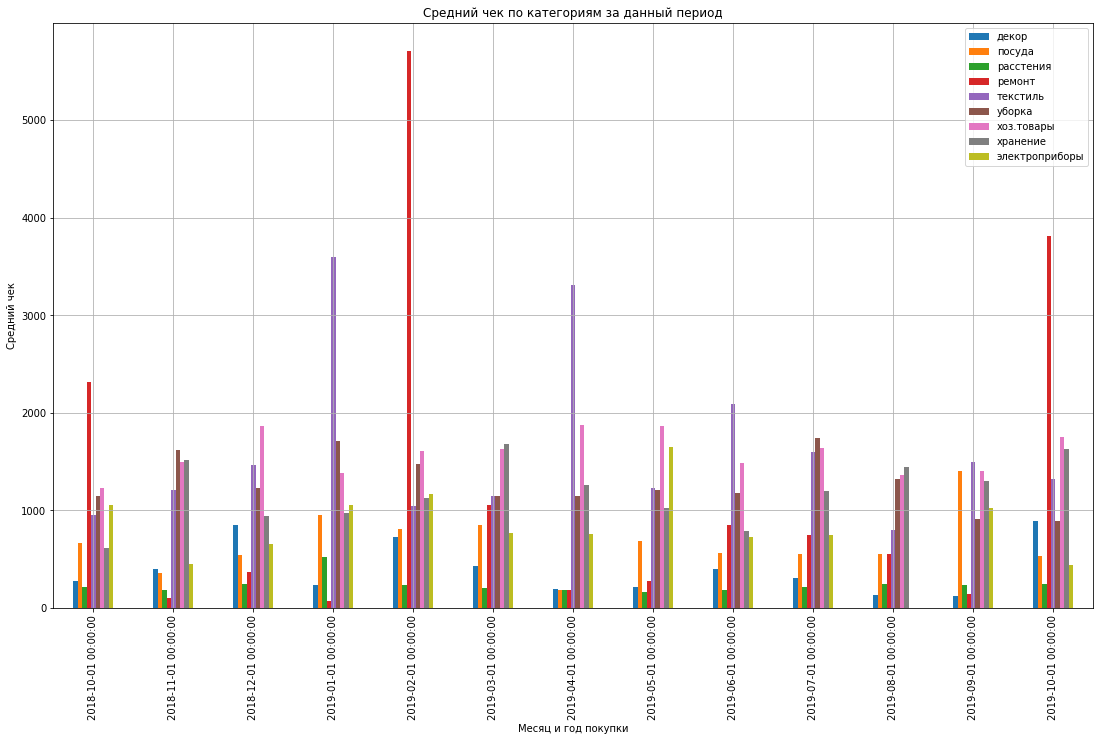

In [69]:
df_check = df.pivot_table(index= 'order_month', columns='segment_group', values='order_price', aggfunc='mean').reset_index()

df_check.plot(kind='bar', x='order_month', ylim=0, grid=True, figsize=(15, 10),legend=False)
plt.legend(loc='upper right')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.title('Средний чек по категориям за данный период')
plt.xlabel('Месяц и год покупки')
plt.ylabel('Средний чек')
plt.show()

Самые высокии средние чеки у категорий товаров: хоз.товары, текстиль и ремонт более 1500 руб. Самый низкий средний чек у категории расстения - 198 руб, при том, что товары этой категории покупают чаще всего.


В феврале 2019 года наблюдается самый высокий средний чек, среди всех категорий за все периоды - т.к. эта категория малочисленна и покупок за месяц крайне мало, рано говорить о какой-либо сезонности, это больше похоже на случайность. 


В январе и апреле 2019 средний чек категории "текстиль" практически больше в 2 раза чем в другие месяца. Возможно это является сезонными колебаниями, связанные с подготовкой к туристическому сезону домов отдыха. Для проверки требуется проанализировать данные еще за 1 год.


Графики и анализ пользователей по категориям:


Рассмотрим пользователей в разрезе категорий покупаемых ими товаров:

In [70]:
display(df_customer_id_1)

,customer_id,segment_count,order_id,order_price,check,segment_name
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,1,555.0,555.000000,расстения
4,ab46eafd-f9d3-4f91-af42-794d675d9c0c,1,1,157.0,157.000000,ремонт
5,ab938608-1b5b-4830-9fc0-dfc649c04b2f,1,1,177.0,177.000000,декор
6,abdc17c8-0813-4b05-9e10-1ffc77eea2d8,1,1,413.0,413.000000,декор
7,abeada3e-b1b7-48e6-b416-4acf56f24898,1,1,222.0,222.000000,расстения
...,...,...,...,...,...,...
4594,0184f535-b60a-4914-a982-231e3f615206,1,5,5891.0,1178.200000,расстения
4624,b7b865ab-0735-407f-8d0c-31f74d2806cc,1,7,3779.0,539.857143,расстения
4642,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,5,17,21361.0,1256.529412,разные категории
4659,4d93d3f6-8b24-403b-a74b-f5173e40d7db,9,35,57278.0,1636.514286,разные категории


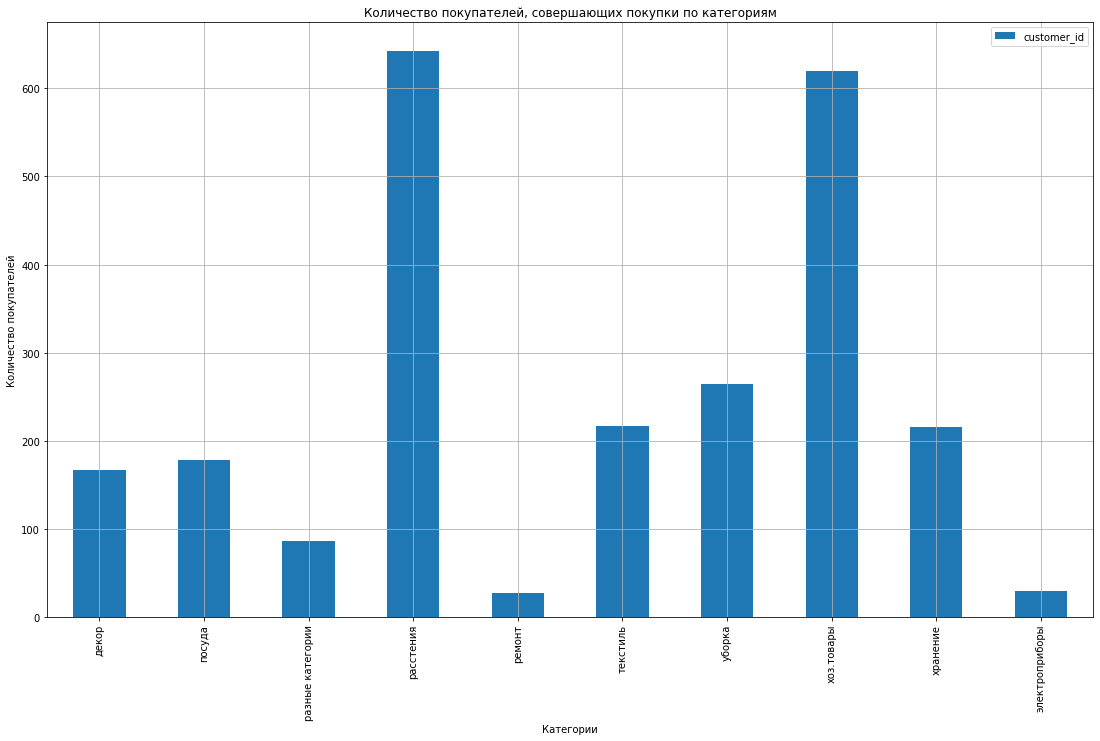

In [71]:
df_customer_id_1_count = df_customer_id_1.pivot_table(index= 'segment_name', values='customer_id', aggfunc='count').reset_index()
df_customer_id_1_count.plot(kind='bar', x='segment_name', ylim=0, grid=True, figsize=(15, 10),legend=False)
plt.legend(loc='upper right')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.title('Количество покупателей, совершающих покупки по категориям')
plt.xlabel('Категории')
plt.ylabel('Количество покупателей')
plt.show()

In [72]:
display(df_customer_id_1_count.sort_values(by = 'customer_id', ascending = False))

,segment_name,customer_id
3,расстения,643
7,хоз.товары,620
6,уборка,264
5,текстиль,217
8,хранение,216
1,посуда,178
0,декор,167
2,разные категории,86
9,электроприборы,29
4,ремонт,27


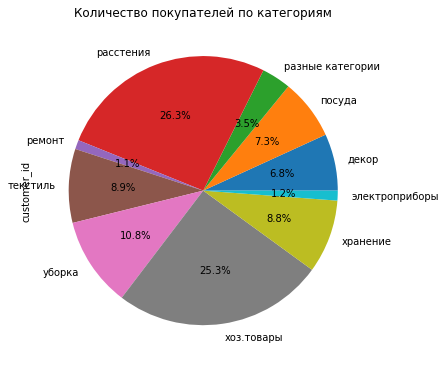

In [73]:
df_customer_id_1.pivot_table(index='segment_name', values='customer_id', aggfunc='count').plot(kind='pie', y='customer_id', x='segment_name', autopct='%1.1f%%',figsize=(6, 6), legend=False)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.title('Количество покупателей по категориям')
plt.show()

Большинство пользователей (более 600 по каждой из категорий) покупают товар в 2-х категориях: расстения и хоз.товары. Чуть меньше 100 пользователей покупают товары в 2-х или более категориях.

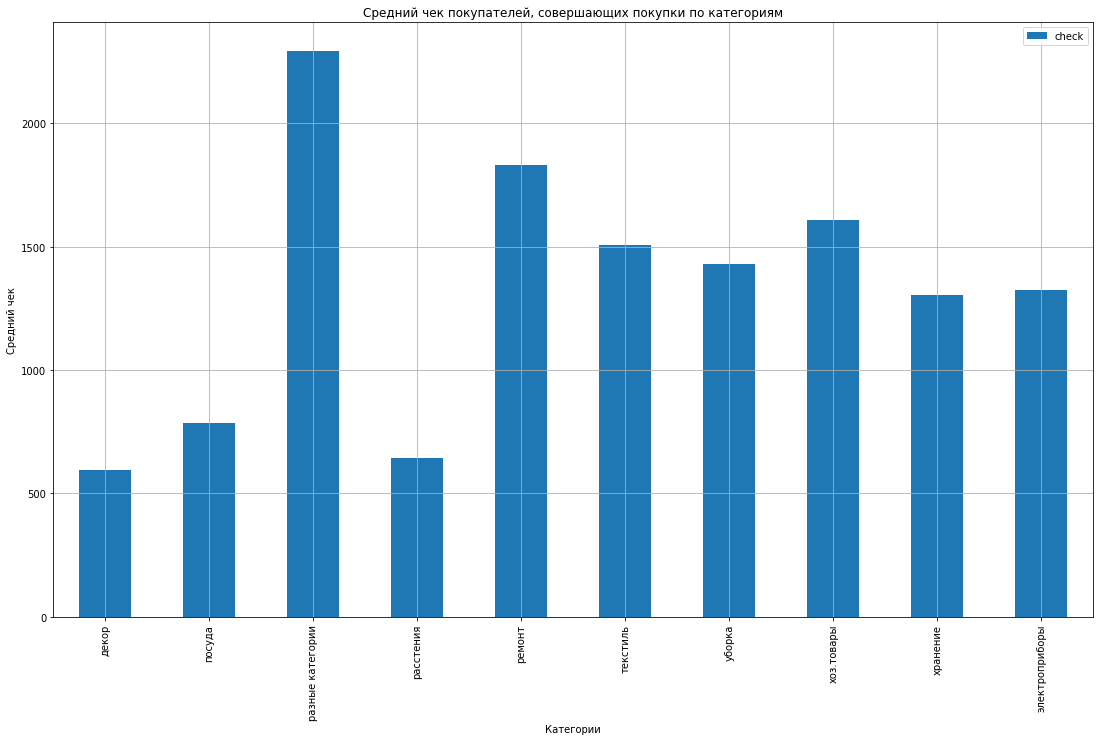

In [74]:
df_customer_id_1_check = df_customer_id_1.pivot_table(index= 'segment_name', values='check', aggfunc='mean').reset_index()
df_customer_id_1_check.plot(kind='bar', x='segment_name', ylim=0, grid=True, figsize=(15, 10),legend=False)
plt.legend(loc='upper right')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.title('Средний чек покупателей, совершающих покупки по категориям')
plt.xlabel('Категории')
plt.ylabel('Средний чек')
plt.show()

In [75]:
display(df_customer_id_1_check.sort_values(by = 'check', ascending = False))

,segment_name,check
2,разные категории,2295.802095
4,ремонт,1832.888889
7,хоз.товары,1606.856720
5,текстиль,1505.739631
6,уборка,1430.174242
9,электроприборы,1324.827586
8,хранение,1305.986111
1,посуда,784.147940
3,расстения,643.405610
0,декор,594.814371


Средний чек покупателей, совершающих покупки в данных категориях самый высокий - более 2000 у тех, кто совершает покупки в 2-х и более категориях. Самый низкий средний у покупателей, совершающих покупки только в категории "расстения" и "декор" - около 600руб

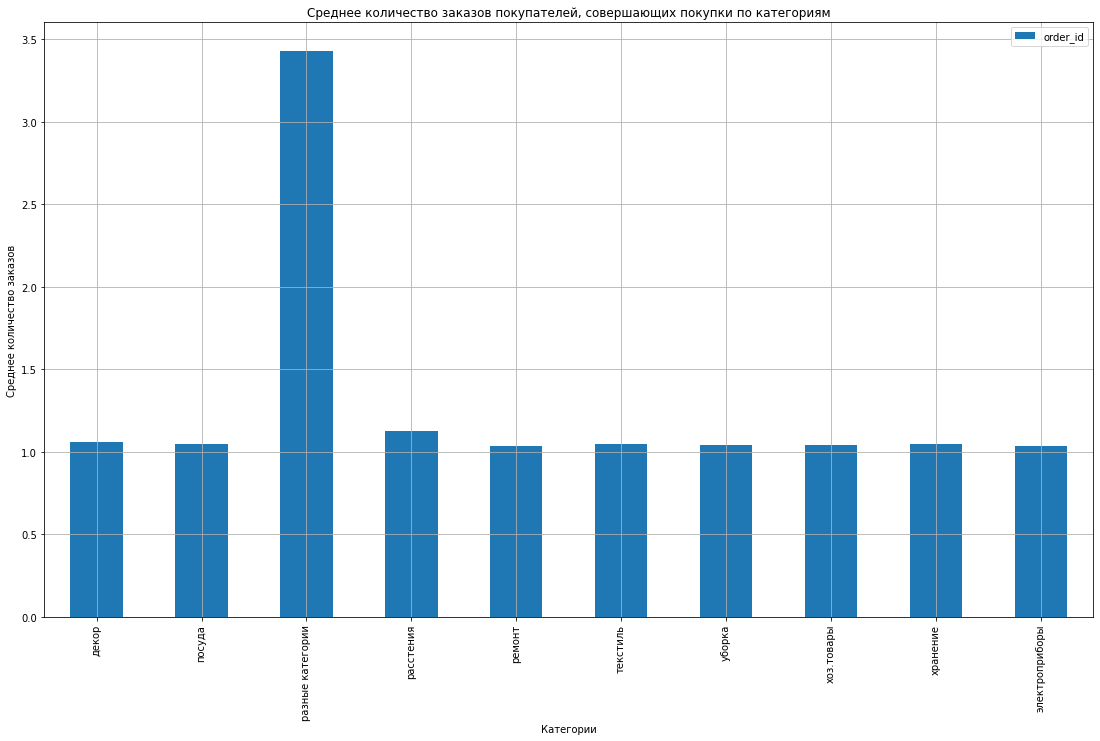

In [76]:
df_customer_id_1_order = df_customer_id_1.pivot_table(index= 'segment_name', values='order_id', aggfunc='mean').reset_index()
df_customer_id_1_order.plot(kind='bar', x='segment_name', ylim=0, grid=True, figsize=(15, 10),legend=False)
plt.legend(loc='upper right')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.title('Среднее количество заказов покупателей, совершающих покупки по категориям')
plt.xlabel('Категории')
plt.ylabel('Среднее количество заказов')
plt.show()

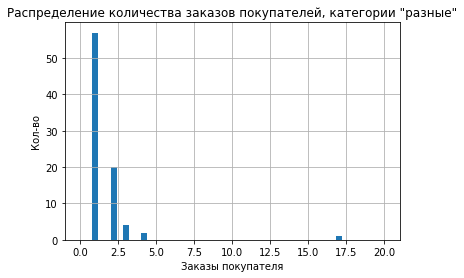

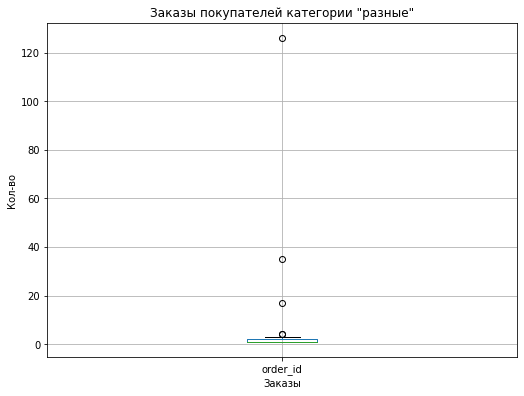

In [77]:
df_customer_id_1.query('segment_name in "разные категории"')['order_id'].hist(bins=50, range = (0, 20)) 
plt.title('Распределение количества заказов покупателей, категории "разные"')
plt.xlabel('Заказы покупателя')
plt.ylabel('Кол-во')
plt.show()
df_customer_id_1.query('segment_name in "разные категории"').boxplot(column='order_id',figsize=(7, 5))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.title('Заказы покупателей категории "разные"')
plt.xlabel('Заказы')
plt.ylabel('Кол-во')
plt.show()

In [78]:
print("Среднее количество заказов покупателей, совершающих заказы в нескольких категориях, после удаления аномальных заказов:")
print(df_customer_id_1.query('segment_name in "разные категории" & order_id <10')['order_id'].mean())

Среднее количество заказов покупателей, совершающих заказы в нескольких категориях, после удаления аномальных заказов:
1.4096385542168675


В среднем один покупатель совершает 1 заказ, покупатели, которые покупают в разных категориях совершают в среднем 1,5 заказа.

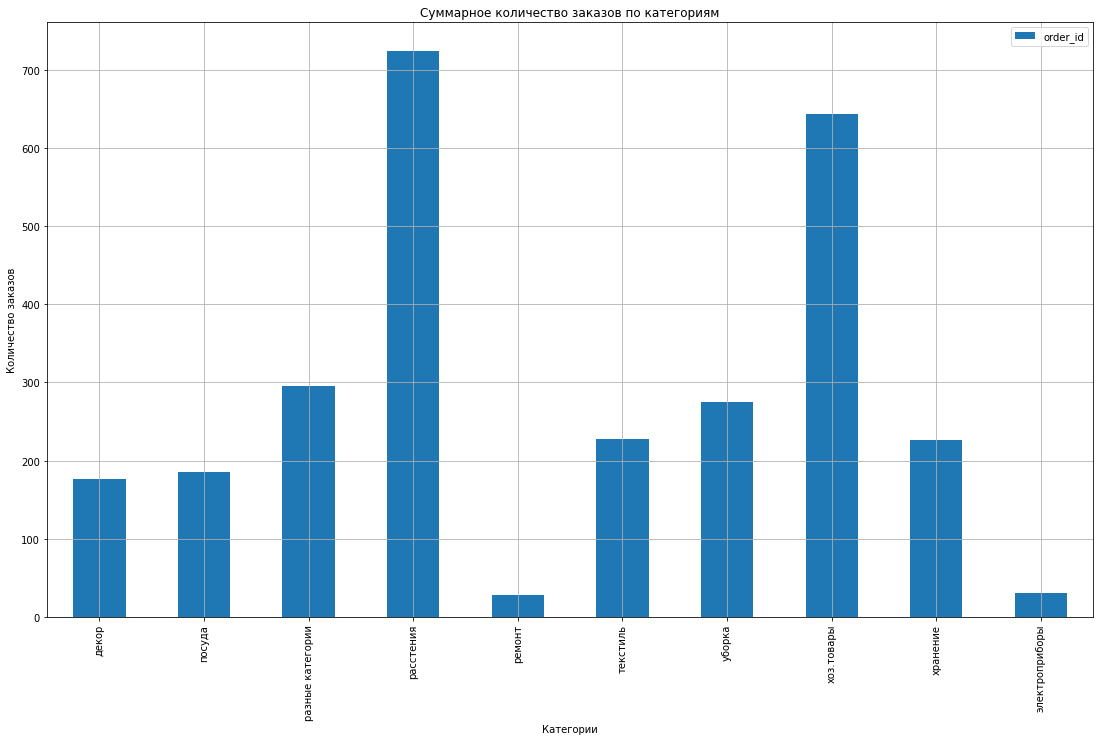

In [79]:
df_customer_id_1_order = df_customer_id_1.pivot_table(index= 'segment_name', values='order_id', aggfunc='sum').reset_index()
df_customer_id_1_order.plot(kind='bar', x='segment_name', ylim=0, grid=True, figsize=(15, 10),legend=False)
plt.legend(loc='upper right')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.title('Суммарное количество заказов по категориям')
plt.xlabel('Категории')
plt.ylabel('Количество заказов')
plt.show()

В сумме по количеству заказов лидирует категории "расстения" и "хоз.товары"

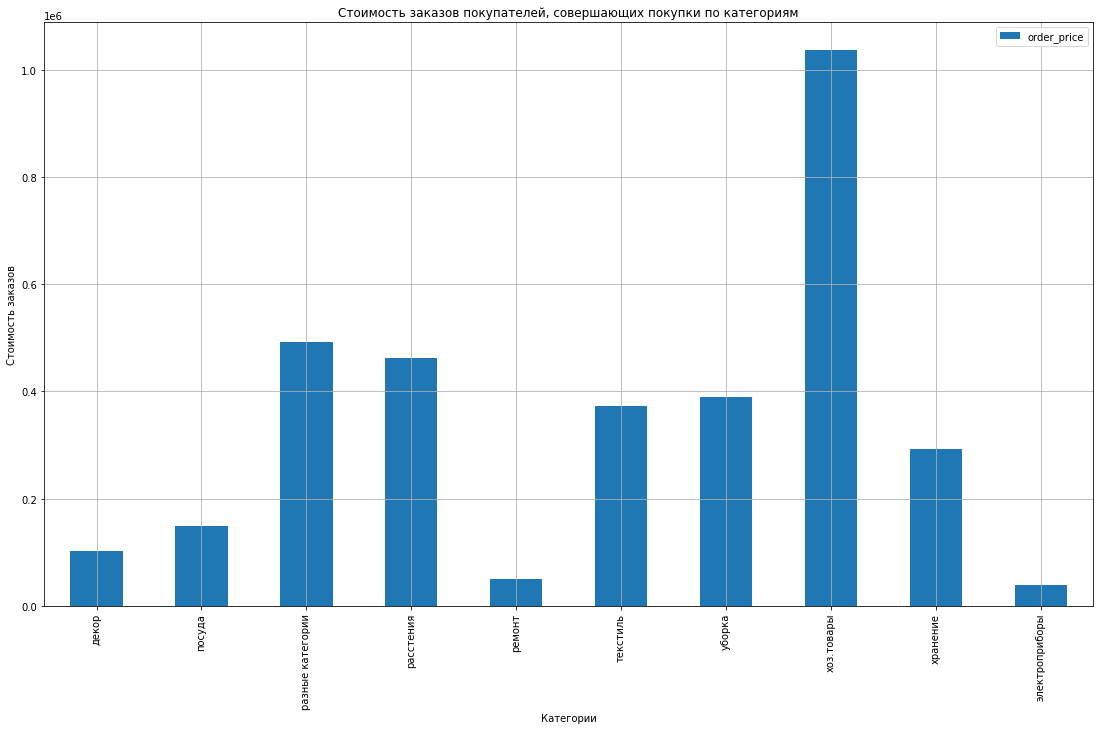

In [80]:
df_customer_id_1_order_sum = df_customer_id_1.pivot_table(index= 'segment_name', values='order_price', aggfunc='sum').reset_index()
df_customer_id_1_order_sum.plot(kind='bar', x='segment_name', ylim=0, grid=True, figsize=(15, 10),legend=False)
plt.legend(loc='upper right')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.title('Стоимость заказов покупателей, совершающих покупки по категориям')
plt.xlabel('Категории')
plt.ylabel('Стоимость заказов')
plt.show()

По стоимости заказов лидирует категория "хоз.товары"

Большинство покупателей совершают покупки только в одной категории - 96,5%. 

Есть 2 категории, в которых покупают большинство покупателей - 26,5% - расстения и 25,3% - хоз.товары - на эти категории приходится и большинство клиентов, и большинство заказов. 

Только 3,5% покупателей приобретают товары в нескольких категориях (от 2-х и более). При этом, у тех, кто совершает покупки в разных категориях самый высокий средний чек - более 2000 и в среднем самое большое количество заказов из расчета на одного клиента (1,5 - против 1 для других категорий).

В стоимости заказов безоговорочным длидером является категория - хоз.товары. Суммарная стоимость заказов клиентов этой категории больше чем в 2 раза выше чем в категории "расстения", "различные товары". 

### Проверка гипотез о равенстве среднего чека двух категорий <a id="gip"></a>

В данной базе также присутствуют 2 группы клиентов, которые делают покупки в категориях: "уборка" и "текстиль". В данных категориях на первый взгляд похожи средние чеки, количество заказов, стоимость заказов. Но все же проверим, есть ли статистически значимая разница между средними чеками заказов. В дальнейшем это поможет нам принять решения, можно ли к этим 2-м группам применять один подход в плане таргетирования

Выдвенем гипотезу, что средние чеки данных категорий равны:

* нулевая гипотеза - средние чеки покупателей категорий уборка и текстиль равны

* альтернативная гипотеза - средние чеки покупателей категорий уборка и текстиль отличаются.

Подготовим срезы данных для 2-х категорий:

In [81]:
df_cl = df_customer_id_1.query('segment_name in "уборка"')
df_tx = df_customer_id_1.query('segment_name in "текстиль"')

Проверим характер распределения стоимости заказов:

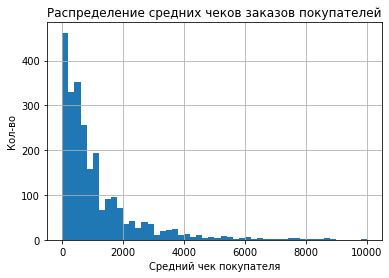

In [82]:
df_customer_id_1['check'].hist(bins=50, range = (0, 10000)) 
plt.title('Распределение средних чеков заказов покупателей')
plt.xlabel('Средний чек покупателя')
plt.ylabel('Кол-во')
plt.show()

Т.к. в данных есть большие (по сравнению с нормальным распределением) выбросы, распределение не является нормальным, то для проверки гипотезы выберем тест, основанный на структурном подходе - критерий Манна-Уитни.

Зададим уровень статистической значимости, равный 5%:

In [83]:
alpha = .05

In [84]:
sample_cl = df_cl['check']
sample_tx = df_tx['check']

In [85]:
results = st.mannwhitneyu(sample_cl, sample_tx)

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя") 


p-значение:  0.5214356865979821
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


Т.к. p-value > 5% - нулевую гипотезу о том, что средние чеки заказов категорий уборка и текстиль равны нельзя отвергнуть. Альтернативную гипотезу, о том. что между стоимосотью заказов категорий есть различия - отвергаем. 

### Выводы и рекомендации <a id="rec"></a>

* В ходе категоризации выделено 9 категорий: электроприборы, хранение, хоз.товары, ремонт, декор, уборка, расстения, посуда, текстиль. Мы поделили пользователей по категориям, в которых они совершают покупки, а также отдельно выделили категорию пользователей, которая совершает покупи в нескольких категоиях.
* по количеству заказов лидирует категории "расстения" и "хоз.товары", при этом средний чек категории "расстения" в 2,5 раза ниже среднего чека категории "хоз.товары". Также в категории "расстения" четко прослеживаются сезонные подъемы и падения продаж - с февраля по май растет количество транзакций в данной категории.
* наиболее высокий средний чек у покупателей, покупающих товары больше чем в одной категории - 2295р. Также среднее количество заказов на одного покупателя у них выше чем у покупателей, покупающих только в одной категории. Средние чеки  в категориях "хоз.товары",  "текстиль", "ремонт", "уборка", "хранение", "электроприборы" также достаточно высокие - более 1300 руб, что в 2 раза выше среднего чека покупателей категории "расстения".
* также определено, что ежедневно в среднем интернет-магазином пользуется 6 уникальных пользователей (44 в месяц и 191 в год). Большинство уникальных пользователей приходится на 12.2018, 02.2019, 03.2019, 04.2019. Минимальное количество пользователей зафиксировано 01.2019 и 06.2019. На эти показатели очень влияет категория "расстения", точнее сезонность этой категории
* 26,3% покупателей совершают покупки только в категории "расстения", думаю, что нужно уделить этой категории отдельное внимание - рассказать о дополнительных товарах, из других категорий, например "текстиль", "уборка", "хоз.товары". Возможно стоит предложить клиентам, покупающим только в категории "расстения" промокод на покупку товаров в других категориях. Цель - "перетянуть" пользователей категории "расстения" в сегмент пользователей, покупающих в 2-х и более категориях. Т.к. это увеличит средний чек заказа и смотивирует покупать не только сезонные товары. 